TensorFlow Version: 2.18.0
Starting Training for 1000 episodes...
Episode: 1/1000, Steps: 1, Score: 0.00, Epsilon: 1.000, MovingAvgReward: 0.00
Episode: 50/1000, Steps: 1, Score: 0.00, Epsilon: 0.909, MovingAvgReward: 0.00
Episode: 100/1000, Steps: 1, Score: 0.00, Epsilon: 0.708, MovingAvgReward: -0.30
Episode: 150/1000, Steps: 1, Score: 0.00, Epsilon: 0.551, MovingAvgReward: -0.60
Episode: 200/1000, Steps: 1, Score: 10.00, Epsilon: 0.429, MovingAvgReward: 0.10
Episode: 250/1000, Steps: 1, Score: -10.00, Epsilon: 0.334, MovingAvgReward: 1.90
Episode: 300/1000, Steps: 1, Score: 0.00, Epsilon: 0.260, MovingAvgReward: 2.00
Episode: 350/1000, Steps: 1, Score: 0.00, Epsilon: 0.202, MovingAvgReward: 1.30
Episode: 400/1000, Steps: 1, Score: -10.00, Epsilon: 0.157, MovingAvgReward: 1.50
Episode: 450/1000, Steps: 1, Score: 10.00, Epsilon: 0.122, MovingAvgReward: 0.80
Episode: 500/1000, Steps: 1, Score: 0.00, Epsilon: 0.095, MovingAvgReward: 1.70
Episode: 550/1000, Steps: 1, Score: 10.00, Epsilo

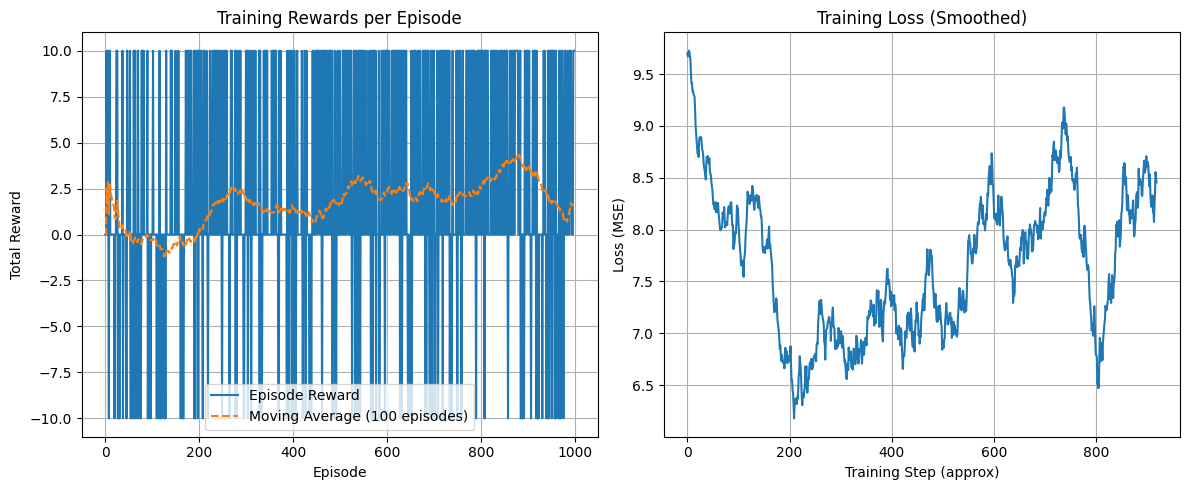

In [1]:
# -*- coding: utf-8 -*-
"""
Simplified LSTM DQN Poker Agent Demo for Google Colab

Demonstrates the structure of using an LSTM within a DQN framework
for a highly simplified poker environment.
"""

# --- 1. Setup and Imports ---
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import random
from collections import deque
import time # To add delays for visualization if needed

print("TensorFlow Version:", tf.__version__)

# --- 2. Highly Simplified Poker Environment ---
# Note: This is extremely basic and doesn't capture poker nuances.
# Focuses only on Heads-Up Limit Hold'em, potentially just one betting round.

class SimplifiedPokerEnv:
    def __init__(self):
        self.deck = list(range(52)) # 0-51 represent cards
        self.n_actions = 3 # 0: Fold, 1: Call/Check, 2: Bet/Raise (fixed amount)
        self.state_size = 6 # [Card1, Card2, Pot, CurrentBet, OpponentLastAction, Round]
                             # OpponentLastAction: -1=None, 0=Fold, 1=Call/Check, 2=Bet/Raise
                             # Round: 0=Preflop (can extend later)
        self.limit_bet = 10 # Fixed bet/raise amount

    def _deal_cards(self):
        random.shuffle(self.deck)
        self.player_hand = [self.deck[0], self.deck[1]]
        self.opponent_hand = [self.deck[2], self.deck[3]]
        # Community cards would be deck[4], deck[5], etc. if needed for flop/turn/river

    def _get_state(self):
        state = np.array([
            self.player_hand[0],
            self.player_hand[1],
            self.pot,
            self.current_bet,
            self.opponent_last_action,
            self.current_round
        ], dtype=np.float32)
        return state

    def reset(self):
        """Starts a new hand."""
        self.deck = list(range(52))
        self._deal_cards()
        self.pot = 0
        self.current_bet = 0 # Amount to call
        self.player_bet_this_round = 0
        self.opponent_bet_this_round = 0
        self.opponent_last_action = -1 # No action yet
        self.current_round = 0 # Preflop
        self.player_turn = True # Assume player acts first for simplicity
        return self._get_state()

    def _opponent_action(self, player_action):
        """Very simple fixed opponent strategy."""
        # Opponent always calls if possible, otherwise checks. Never raises/bets.
        if player_action == 0: # Player folded
             return 0 # Opponent technically wins pot, action irrelevant for next step
        elif player_action == 1: # Player called/checked
            if self.current_bet == 0: # Player checked
                # Opponent also checks
                self.opponent_last_action = 1
                return 1 # Check
            else: # Player called
                 self.opponent_last_action = 1
                 return 1 # Call
        elif player_action == 2: # Player bet/raised
            # Opponent always calls the bet/raise
            self.opponent_last_action = 1
            return 1 # Call

    def _determine_winner(self):
        player_score = sum(self.player_hand)
        opponent_score = sum(self.opponent_hand)
        if player_score > opponent_score:
            return 1 # Player wins
        elif opponent_score > player_score:
            return -1 # Opponent wins
        else:
            return 0 # Tie

    def step(self, action):
        if not self.player_turn:
             raise Exception("Not player's turn")

        done = False
        reward = 0
        info = {}

        # --- Player Action ---
        if action == 0: # Fold
            done = True
            # Player loses whatever they bet this hand
            reward = -self.player_bet_this_round
            self.player_turn = False # End turn

        elif action == 1: # Call/Check
            if self.current_bet == 0: # Check
                # Player checks, bet remains 0
                pass # No change in pot or bet amounts yet
            else: # Call
                call_amount = self.current_bet - self.player_bet_this_round
                self.pot += call_amount
                self.player_bet_this_round += call_amount
                # Calling ends the betting round action from player perspective here
                self.current_bet = 0 # Resetting for opponent's turn? Simplified logic needed

            self.player_turn = False # End player's action turn

        elif action == 2: # Bet/Raise
            bet_amount = self.limit_bet
            call_amount = self.current_bet - self.player_bet_this_round
            total_player_action_cost = call_amount + bet_amount

            self.pot += total_player_action_cost
            self.player_bet_this_round += total_player_action_cost
            self.current_bet = self.player_bet_this_round # The opponent needs to call this amount now

            self.player_turn = False # End player's action turn

        if not done:

            opp_action = self._opponent_action(action)
            self.opponent_last_action = opp_action

            if opp_action == 0:
                 done = True
                 reward = self.pot
            elif opp_action == 1:
                if self.current_bet > 0: # Opponent needs to call player's bet/raise
                    call_amount = self.current_bet - self.opponent_bet_this_round
                    self.pot += call_amount
                    self.opponent_bet_this_round += call_amount
                # If both checked or opponent called, the round might end or proceed
                # Simplified: Assume preflop round ends after this exchange
                done = True # End hand after one round for simplicity
                winner = self._determine_winner()
                if winner == 1:
                    reward = self.opponent_bet_this_round # Player wins what opponent put in
                elif winner == -1:
                    reward = -self.player_bet_this_round # Player loses what they put in
                else: # Tie
                    reward = 0 # Get own bets back essentially (net zero)

            elif opp_action == 2: # Opponent bets/raises (not implemented)
                 pass # Would make the env more complex

            self.current_bet = 0 # Reset for next action/round start
            self.player_bet_this_round = 0
            self.opponent_bet_this_round = 0

        # --- Return results ---
        next_state = self._get_state()
        return next_state, reward, done, info

# --- 3. LSTM DQN Agent ---

class DQNAgent:
    def __init__(self, state_size, action_size, timesteps=1):
        self.state_size = state_size
        self.action_size = action_size
        self.timesteps = timesteps # How many steps LSTM looks back (1 for this simple case)
        self.memory = deque(maxlen=2000) # Experience Replay buffer
        self.gamma = 0.95    # Discount rate
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()
        self.target_model = self._build_model() # Target network
        self.update_target_network() # Initialize target network

    def _build_model(self):
        # LSTM expects input shape: (batch_size, timesteps, features)
        model = keras.Sequential()
        # Input shape needs adjustment if state_size is just features per timestep
        model.add(layers.Input(shape=(self.timesteps, self.state_size)))
        model.add(layers.LSTM(64, activation='relu')) # LSTM layer
        model.add(layers.Dense(32, activation='relu'))
        model.add(layers.Dense(self.action_size, activation='linear')) # Output Q-values
        model.compile(loss='mse', # Mean Squared Error for Q-learning
                      optimizer=keras.optimizers.Adam(learning_rate=self.learning_rate))
        return model

    def update_target_network(self):
        """Copies weights from model to target_model."""
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        """Stores experience in replay memory."""
        # Reshape state and next_state for LSTM: (1, timesteps, features)
        state = np.reshape(state, [1, self.timesteps, self.state_size])
        next_state = np.reshape(next_state, [1, self.timesteps, self.state_size])
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        """Chooses action based on epsilon-greedy policy."""
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size) # Explore

        # Reshape state for LSTM prediction: (1, timesteps, features)
        state = np.reshape(state, [1, self.timesteps, self.state_size])
        act_values = self.model.predict(state, verbose=0) # Get Q-values from model
        return np.argmax(act_values[0])  # Exploit: Choose action with highest Q-value

    def replay(self, batch_size):
        """Trains the model using randomly sampled experiences."""
        if len(self.memory) < batch_size:
            return 0 # Not enough memory yet

        minibatch = random.sample(self.memory, batch_size)

        # Prepare arrays for batch processing
        states = np.zeros((batch_size, self.timesteps, self.state_size))
        next_states = np.zeros((batch_size, self.timesteps, self.state_size))
        actions, rewards, dones = [], [], []

        for i in range(batch_size):
            state, action, reward, next_state, done = minibatch[i]
            states[i,:,:] = state # Already has shape (1, timesteps, state_size)
            actions.append(action)
            rewards.append(reward)
            next_states[i,:,:] = next_state # Already has shape (1, timesteps, state_size)
            dones.append(done)

        # Predict Q-values for current states and next states
        current_q_values = self.model.predict(states, verbose=0)
        # Use target_model for stability when predicting next Q-values
        next_q_values = self.target_model.predict(next_states, verbose=0)

        # Calculate target Q-values using the Bellman equation
        targets = np.copy(current_q_values)
        for i in range(batch_size):
            if dones[i]:
                targets[i, actions[i]] = rewards[i]
            else:
                # Q(s,a) = r + gamma * max_a'(Q_target(s', a'))
                targets[i, actions[i]] = rewards[i] + self.gamma * np.max(next_q_values[i])

        # Train the main model
        history = self.model.fit(states, targets, epochs=1, verbose=0)
        loss = history.history['loss'][0]

        # Decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        return loss

    def load(self, name):
        self.model.load_weights(name)
        self.update_target_network() # Ensure target network is also updated

    def save(self, name):
        self.model.save_weights(name)

# --- 4. Training Loop ---

env = SimplifiedPokerEnv()
state_size = env.state_size
action_size = env.n_actions
agent = DQNAgent(state_size, action_size, timesteps=1) # Using timestep=1 for simple state input

episodes = 1000 # Number of hands to play
batch_size = 32
update_target_freq = 10 # Update target network every C episodes/steps

episode_rewards = []
training_losses = []
moving_avg_rewards = []

print(f"Starting Training for {episodes} episodes...")
start_time = time.time()

for e in range(episodes):
    state = env.reset()
    total_reward = 0
    done = False
    steps = 0 # Steps within an episode (hand)

    while not done:
        steps += 1
        # Agent chooses action
        action = agent.act(state)

        # Environment processes action
        next_state, reward, done, _ = env.step(action)

        # Agent remembers this transition
        agent.remember(state, action, reward, next_state, done)

        # Update state and total reward
        state = next_state
        total_reward += reward

        # Train the agent if enough memory is available
        loss = agent.replay(batch_size)
        if loss > 0 :
             training_losses.append(loss)

        if done:
            # Update target network periodically
            if e % update_target_freq == 0:
                agent.update_target_network()
                # print(f"   Target network updated at episode {e}")

            # Store results for this episode
            episode_rewards.append(total_reward)
            moving_avg = np.mean(episode_rewards[-100:]) # Calculate moving average over last 100 episodes
            moving_avg_rewards.append(moving_avg)

            # Print progress
            if (e + 1) % 50 == 0 or e == 0:
                print(f"Episode: {e+1}/{episodes}, Steps: {steps}, Score: {total_reward:.2f}, Epsilon: {agent.epsilon:.3f}, MovingAvgReward: {moving_avg:.2f}")

            break # Exit while loop for the episode

# --- 5. Save Model and Plot Results ---

print("Training finished.")
end_time = time.time()
print(f"Total Training Time: {end_time - start_time:.2f} seconds")

# Optional: Save the trained model weights
# agent.save("poker_lstm_dqn_simple.weights.h5")
# print("Model weights saved.")

# Plotting Training Rewards
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(episode_rewards, label='Episode Reward')
plt.plot(moving_avg_rewards, label='Moving Average (100 episodes)', linestyle='--')
plt.title('Training Rewards per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.grid(True)

# Plotting Training Loss (if losses were recorded)
if training_losses:
    plt.subplot(1, 2, 2)
    # Smooth the loss plot slightly using a moving average
    loss_moving_avg = np.convolve(training_losses, np.ones(50)/50, mode='valid') # Smooth over 50 steps
    plt.plot(loss_moving_avg)
    plt.title('Training Loss (Smoothed)')
    plt.xlabel('Training Step (approx)')
    plt.ylabel('Loss (MSE)')
    plt.grid(True)

plt.tight_layout()
plt.show()

# --- 6. Optional: Test the Trained Agent (Example) ---
# print("\n--- Testing Trained Agent ---")
# test_episodes = 10
# total_test_reward = 0
# agent.epsilon = 0 # Turn off exploration for testing

# for i in range(test_episodes):
#     state = env.reset()
#     done = False
#     episode_reward = 0
#     print(f"\nTest Hand {i+1}:")
#     print(f"  Player Hand: {env.player_hand}") # In real scenario, hide opponent hand

#     while not done:
#          # Reshape state for prediction
#          current_state_reshaped = np.reshape(state, [1, agent.timesteps, agent.state_size])
#          q_values = agent.model.predict(current_state_reshaped, verbose=0)[0]
#          action = np.argmax(q_values) # Choose best action

#          action_map = {0: "Fold", 1: "Call/Check", 2: "Bet/Raise"}
#          print(f"  State: {state}, Q-Values: {q_values}, Chosen Action: {action_map[action]}")

#          next_state, reward, done, _ = env.step(action)
#          state = next_state
#          episode_reward += reward
#          time.sleep(0.1) # Slow down for visualization

#     print(f"  Hand Result: Reward = {episode_reward}")
#     total_test_reward += episode_reward

# print(f"\nAverage reward over {test_episodes} test hands: {total_test_reward / test_episodes}")

In [2]:
print("\n--- Testing Trained Agent ---")
test_episodes = 10
total_test_reward = 0
agent.epsilon = 0 # Turn off exploration for testing

for i in range(test_episodes):
    state = env.reset()
    done = False
    episode_reward = 0
    print(f"\nTest Hand {i+1}:")
    print(f"  Player Hand: {env.player_hand}") # In real scenario, hide opponent hand

    while not done:
         # Reshape state for prediction
         current_state_reshaped = np.reshape(state, [1, agent.timesteps, agent.state_size])
         q_values = agent.model.predict(current_state_reshaped, verbose=0)[0]
         action = np.argmax(q_values) # Choose best action

         action_map = {0: "Fold", 1: "Call/Check", 2: "Bet/Raise"}
         print(f"  State: {state}, Q-Values: {q_values}, Chosen Action: {action_map[action]}")

         next_state, reward, done, _ = env.step(action)
         state = next_state
         episode_reward += reward
         time.sleep(0.1) # Slow down for visualization

    print(f"  Hand Result: Reward = {episode_reward}")
    total_test_reward += episode_reward

print(f"\nAverage reward over {test_episodes} test hands: {total_test_reward / test_episodes}")


--- Testing Trained Agent ---

Test Hand 1:
  Player Hand: [1, 36]
  State: [ 1. 36.  0.  0. -1.  0.], Q-Values: [-0.02171712  0.00708588 -1.846874  ], Chosen Action: Call/Check
  Hand Result: Reward = 0

Test Hand 2:
  Player Hand: [32, 49]
  State: [32. 49.  0.  0. -1.  0.], Q-Values: [0.20922539 0.06099479 9.940334  ], Chosen Action: Bet/Raise
  Hand Result: Reward = 10

Test Hand 3:
  Player Hand: [22, 0]
  State: [22.  0.  0.  0. -1.  0.], Q-Values: [-0.09985101  0.00711258 -4.0662184 ], Chosen Action: Call/Check
  Hand Result: Reward = 0

Test Hand 4:
  Player Hand: [17, 23]
  State: [17. 23.  0.  0. -1.  0.], Q-Values: [ 0.00412737  0.06444212 -2.558214  ], Chosen Action: Call/Check
  Hand Result: Reward = 0

Test Hand 5:
  Player Hand: [10, 45]
  State: [10. 45.  0.  0. -1.  0.], Q-Values: [ 0.22611666 -0.14774771  4.6332088 ], Chosen Action: Bet/Raise
  Hand Result: Reward = -10

Test Hand 6:
  Player Hand: [41, 5]
  State: [41.  5.  0.  0. -1.  0.], Q-Values: [-0.04241298  0


--- Testing Trained Agent ---

Test Hand 1: Player Hand: [33, 28]
  State: [33. 28.  0.  0. -1.  0.], Q-Vals: [-0.12  0.28  4.33], Action: Bet/Raise
  Hand Result: Reward = 10

Test Hand 2: Player Hand: [24, 19]
  State: [24. 19.  0.  0. -1.  0.], Q-Vals: [ 0.06  0.17 -2.  ], Action: Call/Check
  Hand Result: Reward = 0

Test Hand 3: Player Hand: [2, 30]
  State: [ 2. 30.  0.  0. -1.  0.], Q-Vals: [ 0.03  0.   -3.79], Action: Fold
  Hand Result: Reward = 0

Test Hand 4: Player Hand: [31, 7]
  State: [31.  7.  0.  0. -1.  0.], Q-Vals: [ 0.1   0.01 -1.02], Action: Fold
  Hand Result: Reward = 0

Test Hand 5: Player Hand: [10, 34]
  State: [10. 34.  0.  0. -1.  0.], Q-Vals: [-0.02 -0.1   0.15], Action: Bet/Raise
  Hand Result: Reward = 0
Tested episode 100/500
Tested episode 200/500
Tested episode 300/500
Tested episode 400/500
Tested episode 500/500

--- Testing Finished ---
Total Test Time: 50.91 seconds
Average reward over 500 test hands: 2.660
Standard deviation of rewards: 7.178
Tot

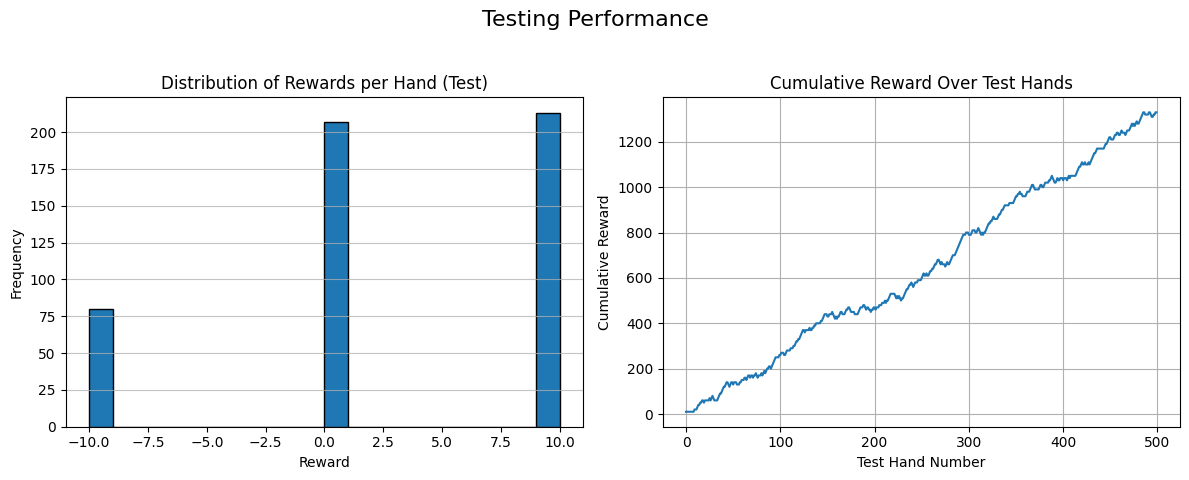


Script finished.


In [4]:
# --- 6. Testing the Trained Agent ---
print("\n--- Testing Trained Agent ---")
test_episodes = 500 # Number of hands to test
test_rewards = []
agent.epsilon = 0 # Turn off exploration for testing

start_test_time = time.time()

for i in range(test_episodes):
    state = env.reset()
    done = False
    episode_reward = 0
    action_map = {0: "Fold", 1: "Call/Check", 2: "Bet/Raise"}

    # Print details for the first few test hands if desired
    verbose_test = i < 5
    if verbose_test:
        print(f"\nTest Hand {i+1}: Player Hand: {env.player_hand}") # In real scenario, hide opponent hand

    while not done:
         # Agent chooses action (training=False disables exploration)
         action = agent.act(state)

         if verbose_test:
             # Reshape state for prediction to show Q-values (optional)
             current_state_reshaped = np.reshape(state, [1, agent.timesteps, agent.state_size])
             q_values = agent.model.predict(current_state_reshaped, verbose=0)[0]
             print(f"  State: {np.round(state,1)}, Q-Vals: {np.round(q_values,2)}, Action: {action_map[action]}")

         next_state, reward, done, _ = env.step(action)
         state = next_state
         episode_reward += reward
         # time.sleep(0.05) # Optional delay

    if verbose_test:
        print(f"  Hand Result: Reward = {episode_reward}")

    test_rewards.append(episode_reward)

    # Print progress for longer tests
    if (i + 1) % 100 == 0:
        print(f"Tested episode {i+1}/{test_episodes}")


end_test_time = time.time()
print(f"\n--- Testing Finished ---")
print(f"Total Test Time: {end_test_time - start_test_time:.2f} seconds")

# Calculate and print test statistics
average_test_reward = np.mean(test_rewards)
std_test_reward = np.std(test_rewards)
print(f"Average reward over {test_episodes} test hands: {average_test_reward:.3f}")
print(f"Standard deviation of rewards: {std_test_reward:.3f}")
print(f"Total cumulative reward during testing: {np.sum(test_rewards):.2f}")


# --- 7. Visualize Test Results ---
plt.figure(figsize=(12, 5))

# Plot Histogram of Test Rewards
plt.subplot(1, 2, 1)
plt.hist(test_rewards, bins=20, edgecolor='black') # Adjust bins as needed
plt.title('Distribution of Rewards per Hand (Test)')
plt.xlabel('Reward')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

# Plot Cumulative Test Reward
plt.subplot(1, 2, 2)
cumulative_rewards = np.cumsum(test_rewards)
plt.plot(cumulative_rewards)
plt.title('Cumulative Reward Over Test Hands')
plt.xlabel('Test Hand Number')
plt.ylabel('Cumulative Reward')
plt.grid(True)

plt.suptitle("Testing Performance", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout
plt.show()

print("\nScript finished.")

<div class="md-recitation">
  Sources
  <ol>
  <li><a href="https://github.com/HareshKarnan/Deep_Q_Learning">https://github.com/HareshKarnan/Deep_Q_Learning</a></li>
  <li><a href="https://github.com/keon/deep-q-learning">https://github.com/keon/deep-q-learning</a> subject to MIT</li>
  <li><a href="https://github.com/rlcode/reinforcement-learning">https://github.com/rlcode/reinforcement-learning</a> subject to MIT</li>
  <li><a href="https://www.cnblogs.com/zeroonegame/p/15037272.html">https://www.cnblogs.com/zeroonegame/p/15037272.html</a></li>
  </ol>
</div>